Seminar Project on NBA player Improvement.

1. Predictive analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data = pd.read_csv(r'https://raw.githubusercontent.com/zxl124/NBA_improvement_prediction/master/data/modified_data.csv', index_col=0)
# Shuffle rows
data = data.sample(frac=1, random_state=42).reset_index(drop=True)
data.head()

,Year,Player,Age,Tm,G,TS%,3PAr,FTr,TRB%,AST%,...,3PA/48,FTA/48,PF/48,MPG,Improvement,Frontcourt,Imprv_prev_year,Tm_WS,Tm_next,Change_team
0,2001.0,Lamar Odom,21,LAC,76.0,0.536,0.242,0.369,11.9,25.0,...,4.282087,6.533145,3.994358,37.315789,-5.80000,1,3.3,34.6,LAC,True
1,2016.0,D.J. Augustin,28,OKC,62.0,0.575,0.480,0.366,4.4,25.3,...,6.845501,5.215620,3.463497,19.000000,-1.40000,0,-0.8,61.9,ORL,False
2,2011.0,Gilbert Arenas,29,ORL,70.0,0.471,0.446,0.208,6.1,25.3,...,8.739421,4.089087,5.024499,25.657143,-0.00303,0,-1.3,54.4,MEM,False
3,2006.0,Matt Carroll,25,CHA,78.0,0.540,0.389,0.353,7.1,4.6,...,6.964706,6.324706,4.517647,16.346154,2.00000,0,1.9,32.5,CHA,True
4,2010.0,Caron Butler,29,WAS,74.0,0.507,0.138,0.300,9.5,9.2,...,2.500898,5.432986,3.328782,37.608108,-2.30000,0,-1.0,34.1,DAL,False


In [3]:
# Separate target data
target = data['Improvement']
data.drop('Improvement', axis=1, inplace=True)
# Drop columns that are not going to be used for modeling.
data.drop(['Year','Player','Tm','Tm_next','WS'], axis=1, inplace=True)
# Since a lot of the features are percentages, I think it makes the most sense to scale the data between 0 and 1.
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

C:\anaconda\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [4]:
# Create training and testing sets
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(scaled_data, target.values, random_state=42)

2. Regression models

2.1 Establishing Benchmark

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
# Find the column index of 'Age'
age_col = data.columns.tolist().index('Age')
# Run the simple linear regression model based on age
lm = LinearRegression()
lm.fit(Xtrain[:,age_col].reshape(-1,1), ytrain)
ypred = lm.predict(Xtest[:,age_col].reshape(-1,1))
print('RMSE of simple linear model is', np.sqrt(mean_squared_error(ytest, ypred)))

RMSE of simple linear model is 2.1564883117402265


2.2 Linear Model

2.2.1 Linear Regression

In [6]:
lm = LinearRegression()
lm.fit(Xtrain, ytrain)
ypred = lm.predict(Xtest)
print('RMSE of linear regression model is', np.sqrt(mean_squared_error(ytest, ypred)))

RMSE of linear regression model is 1.9504359271802103


In [7]:
print(pd.Series(lm.coef_, index=data.columns))
#looking at the coefficients to prioritise features

Age               -3.198378
G                 -1.475999
TS%                0.722493
3PAr               0.081866
FTr               -0.259528
TRB%               1.745498
AST%               1.261267
STL%               0.587352
BLK%               1.105450
TOV%               0.174816
USG%              -2.132952
WS/48             -4.640529
3P%                0.219647
FT%                0.936026
Pick              -0.324906
GS%               -0.655881
FGA/48             1.198250
3PA/48            -0.246015
FTA/48             1.307619
PF/48             -0.601876
MPG                0.326770
Frontcourt        -0.214647
Imprv_prev_year   -6.159739
Tm_WS             -0.026946
Change_team        0.396651
dtype: float64


From coefficients we can see that Age,WS/48 and improvement previous year are the most important features

2.2.2 Ridge Regression

In [8]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
# Grid search alpha and l1_ratio
lm = Ridge(random_state=42)
params = {
    'alpha':[0.01, 0.1, 1, 10]
}
# Write a function that runs GridSearchCv, and output results
def grid_search_cv(regressor, params, Xtrain, ytrain):
    model = GridSearchCV(regressor, params, scoring='neg_mean_squared_error')
    model.fit(Xtrain, ytrain)
    print('Best parameters were', model.best_params_)
    print('Best RMSE was', np.sqrt(-1*model.best_score_))
grid_search_cv(lm, params, Xtrain, ytrain)

Best parameters were {'alpha': 1}
Best RMSE was 1.9996332169169349


C:\anaconda\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [9]:
lm = Ridge(alpha=0.1, random_state=42)
lm.fit(Xtrain, ytrain)
ypred = lm.predict(Xtest)
print('RMSE of Ridge regression model is', np.sqrt(mean_squared_error(ytest, ypred)))

RMSE of Ridge regression model is 1.9504497285205977


In [10]:
print(pd.Series(lm.coef_, index=data.columns))

Age               -3.196312
G                 -1.476110
TS%                0.684139
3PAr               0.087859
FTr               -0.241965
TRB%               1.722241
AST%               1.237227
STL%               0.577313
BLK%               1.096292
TOV%               0.194299
USG%              -2.052639
WS/48             -4.574647
3P%                0.217651
FT%                0.928991
Pick              -0.325021
GS%               -0.654983
FGA/48             1.155323
3PA/48            -0.254575
FTA/48             1.268679
PF/48             -0.599609
MPG                0.323982
Frontcourt        -0.214556
Imprv_prev_year   -6.148446
Tm_WS             -0.040924
Change_team        0.396727
dtype: float64


There was almost no difference between the linear regression model and the Ridge regression model.

2.2.3 Lasso Regression

In [11]:
from sklearn.linear_model import Lasso
# Grid search alpha and l1_ratio
lm = Lasso(random_state=42)
params = {
    'alpha':[1e-6, 1e-5, 1e-4, 0.001, 0.01, 0.1]
}
grid_search_cv(lm, params, Xtrain, ytrain)

C:\anaconda\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best parameters were {'alpha': 0.0001}
Best RMSE was 1.9997064120669004


In [12]:

lm = Lasso(alpha=1e-5, random_state=42)
lm.fit(Xtrain, ytrain)
ypred = lm.predict(Xtest)
print('RMSE of Lasso regression model is', np.sqrt(mean_squared_error(ytest, ypred)))

RMSE of Lasso regression model is 1.950434241675242


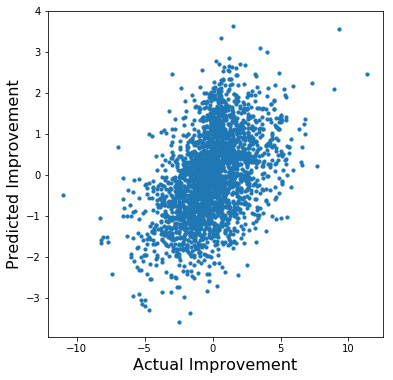

In [13]:

def plot_predict_true(ytest, ypred):
    plt.figure(figsize=(6,6))
    _ = plt.scatter(ytest, ypred, s=10)
    _ = plt.xlabel('Actual Improvement', fontsize=16)
    _ = plt.ylabel('Predicted Improvement', fontsize=16)
plot_predict_true(ytest, ypred)

C:\anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


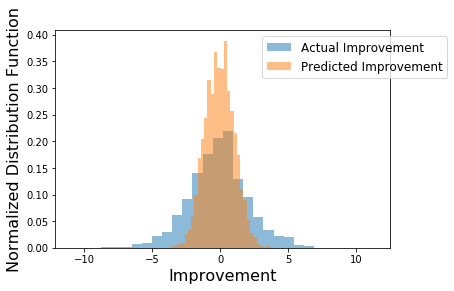

In [14]:

# The prediction space was tighter than the distribution of actual values.
_ = plt.hist(ytest, bins=30, alpha=0.5, normed=True, label='Actual Improvement')
_ = plt.hist(ypred, bins=30, alpha=0.5, normed=True, label='Predicted Improvement')
_ = plt.xlabel('Improvement', fontsize=16)
_ = plt.ylabel('Normalized Distribution Function', fontsize=16)
_ = plt.legend(fontsize=12, bbox_to_anchor=(0.6,1))

In [15]:
 #Try to scale the predicted improvement up to match the range of actual improvements
# and evaluate the performances.
for i in np.linspace(1.5, 3, 16):
    ypred_copy = ypred * i
    print('Factor = {:.1f}, RMSE = {}'.format(i, np.sqrt(mean_squared_error(ytest, ypred_copy))))

Factor = 1.5, RMSE = 2.0310597676350683
Factor = 1.6, RMSE = 2.0631008831199162
Factor = 1.7, RMSE = 2.0999745751609056
Factor = 1.8, RMSE = 2.1414312192741463
Factor = 1.9, RMSE = 2.187210233518802
Factor = 2.0, RMSE = 2.2370462741088915
Factor = 2.1, RMSE = 2.2906745616885997
Factor = 2.2, RMSE = 2.347835247796942
Factor = 2.3, RMSE = 2.4082768200927154
Factor = 2.4, RMSE = 2.471758609120583
Factor = 2.5, RMSE = 2.538052499357577
Factor = 2.6, RMSE = 2.606943966677545
Factor = 2.7, RMSE = 2.678232568218329
Factor = 2.8, RMSE = 2.7517320039752997
Factor = 2.9, RMSE = 2.827269856611885
Factor = 3.0, RMSE = 2.904687100304976


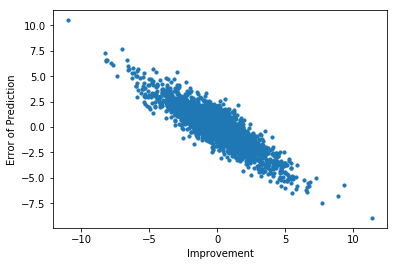

In [16]:
# No, it doesn't work. If I scale up the predictions, error only increase.
# Take a look at residual vs target value
_ = plt.scatter(ytest, ypred-ytest, s=10)
_ = plt.xlabel('Improvement')
_ = plt.ylabel('Error of Prediction')

The errors change with target values. This is not right. Linear regression models should have constant errors regardless of the predicted value. I think the reason we are seeing this is because there are more samples with smaller values(closer to 0) than those with larger values. So the weights of samples are unbalanced in determining the mean squared error. In other words, since there are more samples with smaller values, the models try to prioritize minimizing errors on those samples and tend to ignore samples with larger values. To remedy this, I can assign weights to samples, with weights being inversely proportional to the number of samples with similar target values.

In [17]:
from collections import Counter
def calc_weights(y):
    # Values outside 6 and -6 can be considered outliers and not give too much weight
    y_copy = y.copy()
    y_copy[y_copy>6] = 6
    y_copy[y_copy<-6] = -6
    # Count samples with different target values (using bins with width 1)
    n_samples = Counter(np.round(y_copy, 0))
    # Calculate weights = 1/n(samples with similar y)
    def transform_values(value):
        if value > 6:
            return 1/n_samples[6]
        elif value < -6:
            return 1/n_samples[-6]
        else:
            return 1/n_samples[np.round(value, 0)]
    return np.vectorize(transform_values)(y)
# Calculate weights for training set
ytrain_weights = calc_weights(ytrain)

In [18]:
# Run the linear regression with weights
lm = LinearRegression()
lm.fit(Xtrain, ytrain, sample_weight=ytrain_weights)
ypred = lm.predict(Xtest)

C:\anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


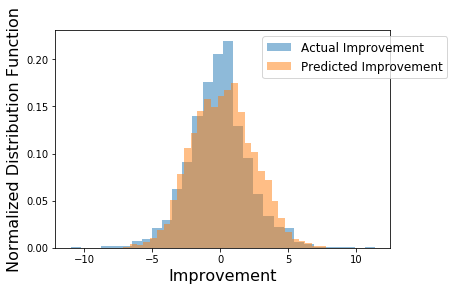

In [19]:
# Check distribution of prediction again
_ = plt.hist(ytest, bins=30, alpha=0.5, normed=True, label='Actual Improvement')
_ = plt.hist(ypred, bins=30, alpha=0.5, normed=True, label='Predicted Improvement')
_ = plt.xlabel('Improvement', fontsize=16)
_ = plt.ylabel('Normalized Distribution Function', fontsize=16)
_ = plt.legend(fontsize=12, bbox_to_anchor=(0.6,1))

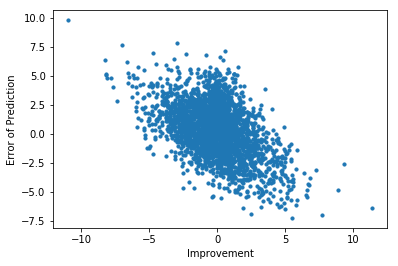

In [20]:
# Check residual and true value again
_ = plt.scatter(ytest, ypred-ytest, s=10)
_ = plt.xlabel('Improvement')
_ = plt.ylabel('Error of Prediction')

With the weighted method, the range of predicted values is more similar to the range of actual values. In terms of errors, it is still not constant across different target values. We can see the weighted model have higher errors for smaller values and lower errors for larger values compared to the unweighted model. Practically speaking, accuracy on larger values is more important than accuracy on smaller values, because players with large improvement/decline have more impact on the team as players whose performance did not change much. So it might be worthwhile to sacrifice some accuracy on the smaller values to achieve higher accuracy on larger values.

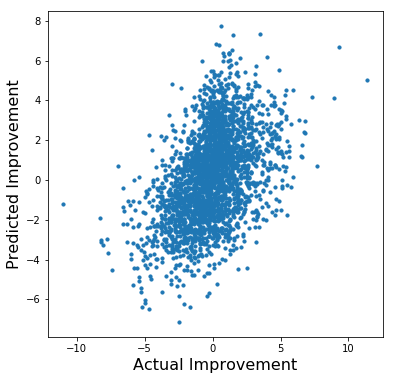

In [21]:
# Plot the prediction against true values again
plot_predict_true(ytest, ypred)

In [22]:
# Recalculate the mean squared error with sample weights
# Calculate sample weights for the test set.
ytest_weights = calc_weights(ytest)
print('The root of weighted squared error of this model is', 
      np.sqrt(mean_squared_error(ytest, ypred, sample_weight=ytest_weights)))

The root of weighted squared error of this model is 2.984420576799354


In [23]:
# Re-evaluate the bench mark model using the same metric.
lm = LinearRegression()
lm.fit(Xtrain[:,age_col].reshape(-1,1), ytrain)
ypred = lm.predict(Xtest[:,age_col].reshape(-1,1))
print('The root of weighted squared error of this model is', 
      np.sqrt(mean_squared_error(ytest, ypred, sample_weight=ytest_weights)))

The root of weighted squared error of this model is 3.839567556276467


We can see that by assigning more weights to under-represented samples (samples with larger improvement/decline), we can achieve higher accuracy for those samples. For other algorithms, I've already gone ahead and tried using standard approaches, and the results are similar in that they all try to focus on over-represented samples, and predict a tighter range of values than the actual improvements. There is no need to show them repeatedly. I am going to use the weighted approach for these algorithms.

2.3 SVM

In [24]:
# GridSearchCV cannot perform the weighted approach I want here.
# I will write my own code to do hyperparameter tuning with 2-fold CV.
from sklearn.model_selection import KFold
from sklearn.svm import SVR
kf = KFold(n_splits=2)
for c in [1, 10, 100, 1000, 10000, 1e5]:
    error = 0
    for train_index, test_index in kf.split(Xtrain, ytrain):
        CV_Xtrain, CV_ytrain = Xtrain[train_index], ytrain[train_index]
        CV_Xtest, CV_ytest = Xtrain[test_index], ytrain[test_index]
        CV_train_weights = calc_weights(CV_ytrain)
        CV_test_weights = calc_weights(CV_ytest)
        clf = SVR(C=c)
        clf.fit(CV_Xtrain, CV_ytrain, sample_weight=CV_train_weights)
        CV_ypred = clf.predict(CV_Xtest)
        error += np.sqrt(mean_squared_error(CV_ytest, CV_ypred, sample_weight=CV_test_weights))
    print("C = {}\tThe root of weighted squared error = {}".format(c,error/2))

C:\anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


C = 1	The root of weighted squared error = 3.895899224835595


C:\anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


C = 10	The root of weighted squared error = 3.688258522554423


C:\anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


C = 100	The root of weighted squared error = 3.231721544345838


C:\anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


C = 1000	The root of weighted squared error = 3.016074874643647


C:\anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


C = 10000	The root of weighted squared error = 2.9661445122975643


C:\anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


C = 100000.0	The root of weighted squared error = 3.0245438794178736


In [25]:
svr = SVR(C=10000)
svr.fit(Xtrain, ytrain, sample_weight=ytrain_weights)
ypred = svr.predict(Xtest)
print('The root of weighted squared error of this model is', 
      np.sqrt(mean_squared_error(ytest, ypred, sample_weight=ytest_weights)))

C:\anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


The root of weighted squared error of this model is 2.861488199684632


C:\anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


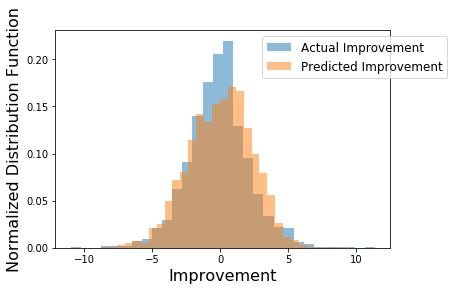

In [29]:
# Check distribution of prediction again
_ = plt.hist(ytest, bins=30, alpha=0.5, normed=True, label='Actual Improvement')
_ = plt.hist(ypred, bins=30, alpha=0.5, normed=True, label='Predicted Improvement')
_ = plt.xlabel('Improvement', fontsize=16)
_ = plt.ylabel('Normalized Distribution Function', fontsize=16)
_ = plt.legend(fontsize=12, bbox_to_anchor=(0.6,1))

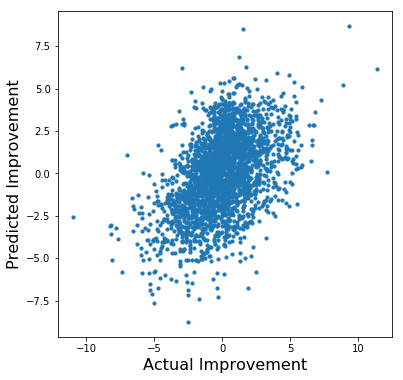

In [30]:
plot_predict_true(ytest, ypred)

RMSE is slightly better than linear models.

2.4. Random Forest

In [ ]:
# Tune n_estimators and min_samples_split
from sklearn.ensemble import RandomForestRegressor
for n in [101, 201, 401, 601, 801, 1001]:
    for m in [10, 100, 200, 300]:
        error = 0
        for train_index, test_index in kf.split(Xtrain, ytrain):
            CV_Xtrain, CV_ytrain = Xtrain[train_index], ytrain[train_index]
            CV_Xtest, CV_ytest = Xtrain[test_index], ytrain[test_index]
            CV_train_weights = calc_weights(CV_ytrain)
            CV_test_weights = calc_weights(CV_ytest)
            clf = RandomForestRegressor(
                random_state=42, n_jobs=-1, n_estimators=n, min_samples_split=m)
            clf.fit(CV_Xtrain, CV_ytrain, sample_weight=CV_train_weights)
            CV_ypred = clf.predict(CV_Xtest)
            error += np.sqrt(mean_squared_error(CV_ytest, CV_ypred, sample_weight=CV_test_weights))
        print("n_estimator = {} min_samples_split = {}\tThe root of weighted squared error = {}".format(n,m,error/2))

n_estimator = 101 min_samples_split = 10	The root of weighted squared error = 3.222912004312924
n_estimator = 101 min_samples_split = 100	The root of weighted squared error = 3.0472045707351505
n_estimator = 101 min_samples_split = 200	The root of weighted squared error = 3.039310062477536
n_estimator = 101 min_samples_split = 300	The root of weighted squared error = 3.0556214848238454
n_estimator = 201 min_samples_split = 10	The root of weighted squared error = 3.210414799173967
n_estimator = 201 min_samples_split = 100	The root of weighted squared error = 3.043972277030526
n_estimator = 201 min_samples_split = 200	The root of weighted squared error = 3.036948533468366
n_estimator = 201 min_samples_split = 300	The root of weighted squared error = 3.051769268729897


In [ ]:
# Run the model with best parameters
rf = RandomForestRegressor(random_state=42, n_estimators=401, min_samples_split=200)
rf.fit(Xtrain, ytrain, sample_weight=ytrain_weights)
ypred = rf.predict(Xtest)
print('The root of weighted squared error of this model is', 
      np.sqrt(mean_squared_error(ytest, ypred, sample_weight=ytest_weights)))

2.5 Gradient Boost

In [ ]:
# Tune max_depth and max_features first
from sklearn.ensemble import GradientBoostingRegressor
for d in [2, 3, 5, 10]:
    for f in ['sqrt', None]:
        error = 0
        for train_index, test_index in kf.split(Xtrain, ytrain):
            CV_Xtrain, CV_ytrain = Xtrain[train_index], ytrain[train_index]
            CV_Xtest, CV_ytest = Xtrain[test_index], ytrain[test_index]
            CV_train_weights = calc_weights(CV_ytrain)
            CV_test_weights = calc_weights(CV_ytest)
            clf = GradientBoostingRegressor(
                random_state=42, min_samples_split=200, max_depth=d, max_features=f)
            clf.fit(CV_Xtrain, CV_ytrain, sample_weight=CV_train_weights)
            CV_ypred = clf.predict(CV_Xtest)
            error += np.sqrt(mean_squared_error(CV_ytest, CV_ypred, sample_weight=CV_test_weights))
        print("max_depth = {} max_features = {}\tThe root of weighted squared error = {}".format(d,f,error/2))

In [ ]:

# Tune learning rate and n_estimators
for n in [51, 101, 201, 401]:
    for l in [0.01, 0.05, 0.1, 0.15]:
        error = 0
        for train_index, test_index in kf.split(Xtrain, ytrain):
            CV_Xtrain, CV_ytrain = Xtrain[train_index], ytrain[train_index]
            CV_Xtest, CV_ytest = Xtrain[test_index], ytrain[test_index]
            CV_train_weights = calc_weights(CV_ytrain)
            CV_test_weights = calc_weights(CV_ytest)
            clf = GradientBoostingRegressor(
                random_state=42, min_samples_split=200, max_depth=2,
                max_features='sqrt', learning_rate=l, n_estimators=n)
            clf.fit(CV_Xtrain, CV_ytrain, sample_weight=CV_train_weights)
            CV_ypred = clf.predict(CV_Xtest)
            error += np.sqrt(mean_squared_error(CV_ytest, CV_ypred, sample_weight=CV_test_weights))
        print("n_estimators = {} learning_rate = {}\tThe root of weighted squared error = {}".format(n,l,error/2))

In [ ]:
gb = GradientBoostingRegressor(
        random_state=42, max_depth=2, max_features='sqrt', min_samples_split=200,
        learning_rate=0.05, n_estimators=201
     )
gb.fit(Xtrain, ytrain, sample_weight=ytrain_weights)
ypred = gb.predict(Xtest)
print('The root of weighted squared error of this model is', 
      np.sqrt(mean_squared_error(ytest, ypred, sample_weight=ytest_weights)))

It appears that SVM was the best model based on the weighted squared error metric.
Regression models are good in answering the "how much will a player improve" question, but sometimes it maybe more useful to answer "will a player improve" or "the probability a player will improve" question, as the answers to these questions are often more straightforward. To answer these, I would use classficiation models.


3. Using classification models

In [ ]:

# Transform the target values into classes
ytrain_class = (ytrain >= 0).astype(int)
ytest_class = (ytest >= 0).astype(int)

3.1 Logistic Regression

In [ ]:

from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=42)
params = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}
# Write a function a run gridsearchcv
def grid_search_cv_class(clf, params, Xtrain, ytrain):
    # Use log loss as evaluation metric because 
    # probabilities are going to be more important than the class prediction.
    model = GridSearchCV(clf, params, scoring='neg_log_loss', n_jobs=-1)
    model.fit(Xtrain, ytrain)
    print('Best parameters were', model.best_params_)
grid_search_cv_class(clf, params, Xtrain, ytrain_class)

In [ ]:
# Check coefficients
logreg = LogisticRegression(C=10, penalty='l2', random_state=42)
logreg.fit(Xtrain, ytrain_class)
coefs = pd.Series(logreg.coef_.reshape(-1), index=data.columns)
print(coefs)

In [ ]:
# Model evaluation using the test set
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, log_loss
def model_evaluation(model, Xtest, ytest):
    ypred = model.predict(Xtest)
    ypred_prob = model.predict_proba(Xtest)
    print('Accuracy of test set was', accuracy_score(ytest, ypred))
    print('Log loss of test set was', log_loss(ytest, ypred_prob), "\n")
    tn, fp, fn, tp = confusion_matrix(ytest, ypred).ravel()
    print('True Negative = {}\tFalse Positive = {}\nFalse Negative = {}\tTrue Positive={}'
          .format(tn,fp,fn,tp))
    print("\n")
    print(classification_report(ytest, ypred))
model_evaluation(logreg, Xtest, ytest_class)

In [ ]:
# Plot the predicted probability and true values
def plot_prob_value(model, Xtest, ytest):
    ypred = model.predict_proba(Xtest)[:,1]
    plt.figure(figsize=(6,6))
    _ = plt.scatter(ytest, ypred, s=10)
    _ = plt.xlabel('Actual Player Improvement', fontsize=16)
    _ = plt.ylabel('Predicted Probability', fontsize=16)
plot_prob_value(logreg, Xtest, ytest)

3.2 SVM

In [ ]:
from sklearn.svm import SVC
clf = SVC(random_state=42, probability=True)
params = {
    'C': [10, 100, 1000, 10000],
    'gamma': [1e-4, 0.001, 0.01, 0.1, 1, 10]
}
grid_search_cv_class(clf, params, Xtrain, ytrain_class)

In [ ]:
svc = SVC(random_state=42, probability=True, C=10000, gamma=0.001)
svc.fit(Xtrain, ytrain_class)
model_evaluation(svc, Xtest, ytest_class)

In [ ]:
plot_prob_value(svc, Xtest, ytest)


Very similar performances between logistic regression and SVM.

3.3 Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=42)
params = {
    'n_estimators': [101, 201, 401, 601, 801, 1001],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 10, 20],
}
grid_search_cv_class(clf, params, Xtrain, ytrain_class)

In [ ]:
rf = RandomForestClassifier(
                   n_estimators=601, max_depth=10, min_samples_split=2,
                   random_state=42)
rf.fit(Xtrain, ytrain_class)
model_evaluation(rf, Xtest, ytest_class)

In [ ]:
# Plot feature importances.
imp = pd.Series(rf.feature_importances_, index=data.columns)
imp = imp.sort_values(ascending=False)
plt.figure(figsize=(10,5))
_ = plt.bar(range(len(imp)), imp)
_ = plt.xticks(range(len(imp)), imp.index, rotation=90)
_ = plt.xlabel('Features', fontsize=16)
_ = plt.ylabel("Feature Importance", fontsize=16)
_ = plt.xticks(fontsize=12)
_ = plt.yticks(fontsize=12)


3.4 Gradient Boost

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
# Use some tuned parameters from random forest, only tune learning rate and n_estimators
clf = GradientBoostingClassifier(
                    min_samples_split=2, max_depth=10,
                    max_features='sqrt', random_state=42)
params = {
    'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1],
    'n_estimators': [25, 51, 101, 201, 401, 601, 1001],
}
grid_search_cv_class(clf, params, Xtrain, ytrain_class)

In [ ]:
gb = GradientBoostingClassifier(
                    min_samples_split=2, max_depth=10,
                    max_features='sqrt', random_state=42,
                    learning_rate=0.01, n_estimators=201)
gb.fit(Xtrain, ytrain_class)
model_evaluation(gb, Xtest, ytest_class)

The random forest model had the best performances out of all, but not by much

3.5 Voting Model

In [ ]:
from sklearn.ensemble import VotingClassifier
# Make a weights matrix
weights = [[int(x) for x in list("{0:0b}".format(i).zfill(4))] for i in range(1, 2**4)]
print('Weights matrix is', weights)
# Use CV to figure which models to use in the ensumble model
clf = VotingClassifier(
    estimators=[('logreg', logreg), ('svc', svc), ('rf', rf), ('gb', gb)],
    voting='soft')
params = {'weights': weights}
grid_search_cv_class(clf, params, Xtrain, ytrain_class)

In [ ]:
voting = VotingClassifier(
    estimators=[('logreg', logreg), ('svc', svc), ('gb', gb)],
    voting='soft', weights = [1,1,1])
voting.fit(Xtrain, ytrain_class)
model_evaluation(voting, Xtest, ytest_class)

In [ ]:
plot_prob_value(voting, Xtest, ytest)

3.6 ROC curve

In [ ]:
# Plot the precision-recall curve of different models on the test set.
from sklearn.metrics import roc_curve
models = [logreg, svc, rf, gb, voting]
labels = ['Logistic Regression', 'Support Vector Machine',
          'Random Forest', 'Grandient Boosting', 'Voting']
colors = ['red', 'yellow', 'green', 'blue', 'purple']
plt.figure(figsize=(8,8))
for index, model in enumerate(models):
    ypred_prob = model.predict_proba(Xtest)[:,1]
    fpr, tpr, _ = roc_curve(ytest_class, ypred_prob)
    _ = plt.step(fpr, tpr, color=colors[index], alpha=0.5, where='post', label=labels[index])
random = np.random.rand(len(ytest))
fpr, tpr , _ = roc_curve(ytest_class, random)
_ = plt.step(fpr, tpr, color='k', alpha=0.5, where='post', label='Random')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.legend(fontsize=12)


In this problem, we want the false positive rate to be lower. In other words, it is OK to have false negatives (miss some improved players), since a team can only have a limited number of players. But it is really bad to have false positives, because acquiring that player probably means loss of value for the team.

In [ ]:
# Re-do the roc curve, but zoom in for false positive rate < 0.2
models = [logreg, svc, rf, gb, voting]
labels = ['Logistic Regression', 'Support Vector Machine',
          'Random Forest', 'Grandient Boosting', 'Voting']
colors = ['red', 'yellow', 'green', 'blue', 'purple']
plt.figure(figsize=(8,8))
for index, model in enumerate(models):
    ypred_prob = model.predict_proba(Xtest)[:,1]
    fpr, tpr, _ = roc_curve(ytest_class, ypred_prob)
    _ = plt.step(fpr, tpr, color=colors[index], alpha=0.5, where='post', label=labels[index])
random = np.random.rand(len(ytest))
fpr, tpr , _ = roc_curve(ytest_class, random)
_ = plt.step(fpr, tpr, color='k', alpha=0.5, where='post', label='Random')
_ = plt.xlim([0, 0.2])
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.legend(fontsize=12)


It seems like the voting model was on or near the top in most cases. But the differences between models were very very small.